# Evaluierung eines PID-gesteuerten Agenten in der LunarLander-v3-Umgebung

@Autor Michael Greif

In dieser Demonstration wird die Leistung eines Agenten evaluiert, der mittels PID-Reglern in der LunarLander-v3-Umgebung von OpenAI Gym gesteuert wird. Die Aufgabe des Agenten besteht darin, ein Raumschiff sicher auf einer Plattform zu landen, wobei er drei wesentliche Dimensionen steuern muss:

1. **Vertikale Position**: Das Raumschiff soll sanft auf der Plattform landen.
2. **Horizontale Position**: Das Raumschiff soll über der Plattform zentriert bleiben.
3. **Winkel**: Das Raumschiff soll in einer aufrechten Position ohne Neigung landen.

Für jede dieser Dimensionen wurde ein separater PID-Regler implementiert, um präzise Steuerbefehle basierend auf dem aktuellen Zustand des Raumschiffs zu generieren. Diese Regler helfen dabei, die Abweichungen vom gewünschten Zustand zu minimieren.

Die Simulation wird über eine Reihe von Episoden durchgeführt, um die Effizienz dieser Steuerstrategie zu analysieren. Am Ende jeder Episode werden die Gesamtrewards und die Landungspunkte des Raumschiffs ausgegeben. Darüber hinaus wird eine statistische Auswertung über mehrere Episoden gegeben, um die durchschnittliche Punktezahl und die durchschnittliche Landungsgenauigkeit zu berechnen.

# Verwendete Bibliotheken

Bibliotheksreferenzen
- OpenAI Gymnasium: https://gymnasium.farama.org/
- NumPy: https://numpy.org/
- Matplotlib: https://matplotlib.org/

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# PID Controller Class

Der PID-Controller im folgenden Code ist eine Implementierung eines Proportional-Integral-Derivative (PID) Reglers, der in Steuerungssystemen weit verbreitet ist. Dieser Regler zielt darauf ab, eine dynamische Prozesssteuerung zu ermöglichen, indem er kontinuierlich die Differenz (Fehler) zwischen einem gewünschten Sollwert und einem aktuellen Istwert analysiert und darauf reagiert. Der PID-Regler beeinflusst den Steuerungsoutput durch drei 

**Kernkomponenten**:

- **Proportionaler Anteil (Kp)**: Dieser Teil des Reglers reagiert direkt proportional zum aktuellen Fehlerwert. Er veranlasst umso stärkere Anpassungen, je weiter der Istwert vom Sollwert abweicht. Ein gut abgestimmter Kp-Wert hilft, schnelle Korrekturen vorzunehmen, kann aber auch zu Instabilitäten führen, wenn er zu hoch ist.

- **Integraler Anteil (Ki)**: Der Integralaspekt adressiert die Summe der vergangenen Fehler über die Zeit. Er korrigiert stetige Abweichungen, die sich im Zeitverlauf aufsummieren, und sorgt dafür, dass der Regler keine dauerhafte Diskrepanz zwischen Soll- und Istwert besitzt.

- **Derivativer Anteil (Kd)**: Dieser Bestandteil gibt Aufschluss über die Geschwindigkeit der Fehlerveränderung und ist entscheidend zur Dämpfung des Systems. Er reduziert die Reaktion auf große Fehler, wenn der Istwert schnell auf den Sollwert zusteuert, und verhindert Überschwinger.

Die Methode `update` des PID-Controllers berechnet den Steuerungsoutput basierend auf den Werten dieser drei Parameter und dem gegebenen Fehler. Die Methode `reset` dient zur Initialisierung der vorhergehenden Fehler und der Integralsumme, falls ein Neustart oder ein erneuter Steuerprozess notwendig ist.

In [2]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        # Initialisiert den PID-Controller mit den gegebenen Koeffizienten
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def reset(self):
        # Setzt die gespeicherten Zustände zurück
        self.prev_error = 0
        self.integral = 0

    def update(self, error, dt):
        # Berechnet den Ausgang des PID-Reglers auf Basis des aktuellen Fehlers
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output

# Funktion zum Testen der Controller

Zu Beginn wird die Umgebung initialisiert und drei PID-Regler werden mit spezifischen Koeffizienten für proportionale, integrale und differentiale Anteile konfiguriert. Diese Regler steuern jeweils die vertikale Bewegung, die horizontale Bewegung und den Neigungswinkel des Raumschiffs.

Die Simulation läuft über mehrere Episoden. In jeder Episode startet das Raumschiff in einem zufälligen Zustand, und die Regler werden zurückgesetzt, um Änderungen im Steuerungsverhalten zwischen den Episoden zu verhindern. Innerhalb jeder Episode berechnet der Code kontinuierlich die Differenz (Fehler) zwischen dem aktuellen und dem gewünschten Zustand des Raumschiffs. Anhand dieser Fehler bestimmen die PID-Regler entsprechende Steuerungsaktionen.

Der Code umfasst eine Schleife, die bis zum Abschluss jeder Episode läuft. Während dieser Schleife werden die Steuerbefehle basierend auf den berechneten Fehlern aktualisiert, und die resultierenden Aktionen werden auf die Umgebung angewendet. Jede Aktion beeinflusst den Zustand des Raumschiffs und generiert eine Belohnung, die zur Gesamtbelohnung der Episode addiert wird. Wenn das Raumschiff sicher gelandet ist, wird die Episode beendet. Am Ende jeder Episode werden die erzielten Ergebnisse ausgegeben.

Zusätzlich wird ein Überblick über die Leistung in allen durchgeführten Episoden gegeben. Die durchschnittlichen Belohnungen und die Präzision der Landungen werden ausgewertet, um die Effektivität der verwendeten PID-Regler zu beurteilen.

In [3]:
def evaluate_pid(n_episodes=5, verbose=0, render_mode=None):
    """
    Evaluierung eines PID-gesteuerten Agenten in der LunarLander-v3-Umgebung für eine bestimmte Anzahl von Episoden.

    :param n_episodes: Anzahl der Episoden, die ausgeführt werden sollen (Standardwert ist 5).
    :param verbose: Grad der Detailtiefe für Debug-Ausgaben (Standardwert ist 0, was keine Debug-Ausgabe bedeutet).
    :param render_mode: Modus zum Rendern der Umgebung (Standard ist None, was kein Rendering bedeutet).

    Die Funktion verwendet drei separate PID-Regler zur Steuerung der vertikalen Position, horizontalen Position und des Winkels des Landers. 
    Sie berechnet die Fehler zwischen dem aktuellen und dem gewünschten Zustand, aktualisiert die Aktionen über die PID-Regler und wendet 
    Aktionen auf die Umgebung an. Ziel jeder Episode ist es, das Raumschiff sicher auf der Plattform zu landen und die Geschwindigkeit 
    bei der Landung zu minimieren.
    """
    # Erstelle die Gym-Umgebung mit einer spezifischen Gravitätseinstellung
    env = gym.make("LunarLander-v3", gravity=-10.0, render_mode=render_mode)
    
    # Initialisiere PID-Regler für die vertikale, horizontale Steuerung und den Winkel
    vertical_pid = PIDController(Kp=4.0, Ki=0.5, Kd=1.0)
    horizontal_pid = PIDController(Kp=2.0, Ki=2.0, Kd=0.5)
    angle_pid = PIDController(Kp=4.0, Ki=2.0, Kd=0.3)
    
    total_rewards = []  # Liste zur Speicherung der Gesamtreward pro Episode
    x_cords = []          # Liste zur Speicherung der finalen x-Koordinate der Landung pro Episode

    # Schleife durch jede Episode
    for episode in range(n_episodes):
        state, _ = env.reset()  # Setze die Umgebung für eine neue Episode zurück
        vertical_pid.reset()    # Setze den vertikalen PID-Regler zurück
        horizontal_pid.reset()  # Setze den horizontalen PID-Regler zurück
        angle_pid.reset()       # Setze den Winkel-PID-Regler zurück
        total_reward = 0        # Akkumulator für den Gesamtreward
        done = False            # Flag zur Anzeige des Endes der Episode
        
        # Schleife, bis die Episode beendet ist
        while not done:
            # Entpacke den aktuellen Zustand
            coord_x, coord_y, velocity_x, velocity_y, angle, velocity_angle, left_foot, right_food = state
            
            # Zielzustände für die Steuerung (Sollwerte)
            target_y = 0.0
            target_x = 0.0
            target_angle = 0.0

            # Berechne die Fehler für jede Steuerungsdimension
            y_error = target_y - coord_y - velocity_y * 2
            x_error = target_x + coord_x + velocity_x * 2
            angle_error = target_angle - angle - velocity_angle
            
            # Zeitschritt für die PID-Aktualisierung
            dt = 1.0 / 50.0 

            # Aktualisiere die PID-Regler und erhalte die Steueraktionen
            y_action = vertical_pid.update(y_error, dt)
            x_action = horizontal_pid.update(x_error, dt)
            theta_action = angle_pid.update(angle_error, dt)
            
            if verbose:
                # Debug-Informationen ausgeben, wenn Verbosität aktiviert ist
                print("y: ", coord_y, "v: ", velocity_y, end=" ")
                print("Fehler: ", y_error, "Output: ", y_action)
                print("x: ", coord_x, "v: ", velocity_x, end=" ")
                print("Fehler: ", x_error, "Output: ", x_action)
                print()
            
            # Bestimme die Aktionen basierend auf den Steuerergebnissen
            vertical_action = 2 if y_action > 0 else 0
            horizontal_action = 1 if x_action > 0 else 3
            angle_action = 1 if theta_action > 0 else 3

            # Wähle die endgültige Aktion
            action = vertical_action
            if vertical_action == 0:
                action = horizontal_action if abs(x_action) > abs(theta_action) else angle_action

            # Wende die ausgewählte Aktion auf die Umgebung an
            state, reward, done, _, _ = env.step(action)
            if left_foot and right_food and abs(velocity_y) < 0.005:
                done = True  # Beende die Episode, wenn das Raumschiff erfolgreich landet
            total_reward += reward  # Summiere die Belohnung auf
        
        # Speichere die Ergebnisse der Episode
        x_cords.append(abs(coord_x))
        total_rewards.append(total_reward)
        
        # Episode-Zusammenfassung ausgeben
        print(f"Episode {episode + 1}: {total_reward}")
        print(f"Landung auf ({coord_x:.2f},{coord_y:.2f}) mit Geschwindigkeit = {velocity_y:.2f}")
        print()
    
    env.close()  # Schließe die Umgebung, sobald alle Episoden abgeschlossen sind
    
    # Endergebnisse ausgeben
    print(f"Durchschnittliche Punktzahl über {episode + 1} Episoden: {np.mean(total_rewards)}")
    print(f"Durchschnittliche Entfernung zu x=0.00 über {episode + 1} Episoden: {abs(np.mean(x_cords)):.3f}")
    
    return total_rewards, x_cords

# Testing

Die Funktion `evaluate_pid` wird mit `n_episodes=1000` aufgerufen, um den PID-gesteuerten Agenten in der "LunarLander-v3"-Umgebung über 1000 Episoden auszuwerten. Dabei wird das Verhalten des Raumschiffs gesteuert, um es sicher auf einer Plattform zu landen. Die Funktion nutzt drei PID-Regler, um die vertikale und horizontale Bewegung sowie die Neigung des Raumschiffs zu kontrollieren. In jeder Episode wird der aktuelle Zustand des Raumschiffs kontinuierlich mit dem Zielzustand verglichen, um entsprechende Steuerbefehle zu berechnen und anzuwenden. Nach jeder Episode werden die Gesamtbelohnungen und Landungspräzisionen festgehalten, um die mittlere Leistung und Landungsgenauigkeit über alle 1000 Episoden hinweg zu bewerten. Dies ermöglicht eine umfassende Analyse der Effektivität und Anpassung der PID-Regler.

In [4]:
total_rewards, x_cords = evaluate_pid(n_episodes=1000)

Episode 1: 194.31720492616202
Landung auf (-0.05,-0.00) mit Geschwindigkeit = 0.00

Episode 2: 167.02605459737055
Landung auf (-0.06,-0.01) mit Geschwindigkeit = -0.00

Episode 3: 141.81321375044652
Landung auf (0.00,-0.01) mit Geschwindigkeit = -0.00

Episode 4: 147.17097705634043
Landung auf (0.02,-0.01) mit Geschwindigkeit = -0.00

Episode 5: 163.65327966855983
Landung auf (-0.00,-0.01) mit Geschwindigkeit = 0.00

Episode 6: 172.78529859930168
Landung auf (0.06,-0.01) mit Geschwindigkeit = -0.00

Episode 7: 150.7669583188264
Landung auf (0.01,-0.01) mit Geschwindigkeit = 0.00

Episode 8: 184.19825301188905
Landung auf (-0.02,-0.01) mit Geschwindigkeit = -0.00

Episode 9: 121.17852117192291
Landung auf (0.02,-0.00) mit Geschwindigkeit = -0.00

Episode 10: 170.65800853971479
Landung auf (0.03,-0.01) mit Geschwindigkeit = 0.00

Episode 11: 174.97477241334704
Landung auf (0.02,-0.01) mit Geschwindigkeit = -0.00

Episode 12: 134.14842318675824
Landung auf (0.03,-0.01) mit Geschwindigkeit

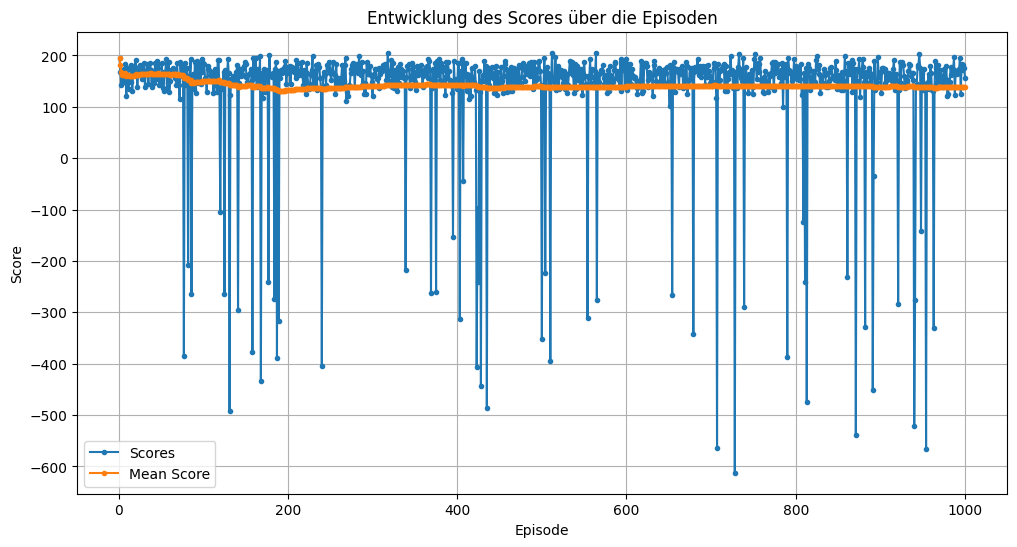

In [5]:
# Plot: Scores über Episoden
plt.figure(figsize=(12, 6))
plt.plot(range(1, 1001), total_rewards, marker=".", label="Scores")
plt.plot(range(1, 1001), [np.mean(total_rewards[:x]) for x in range(1, 1001)], marker=".", label="Mean Score")
plt.title('Entwicklung des Scores über die Episoden')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Score')
plt.grid()
plt.show()

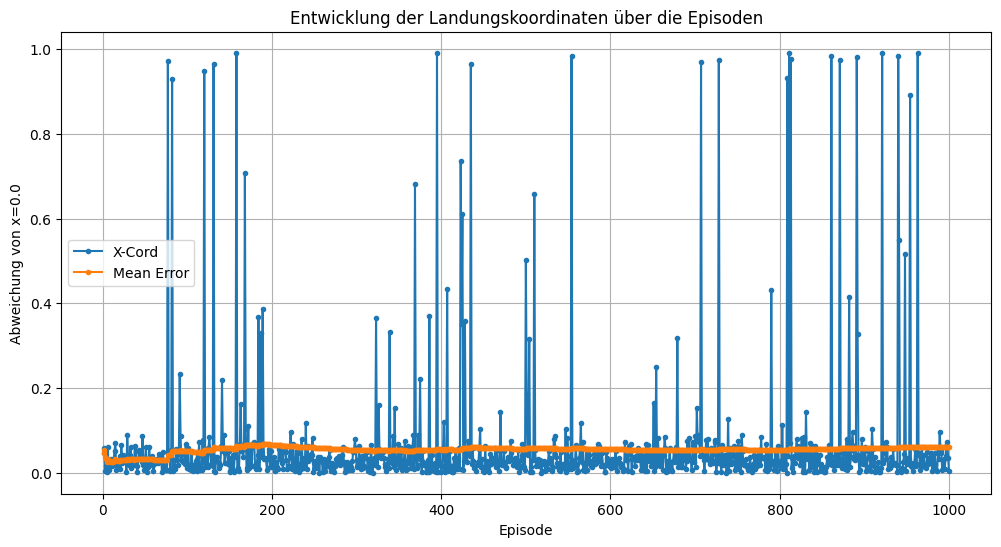

In [6]:
# Plot: Entfernung zu x=0
plt.figure(figsize=(12, 6))
plt.plot(range(1, 1001), x_cords, marker=".", label="X-Cord")
plt.plot(range(1, 1001), [np.mean(x_cords[:x]) for x in range(1, 1001)], marker=".", label="Mean Error")
plt.title('Entwicklung der Landungskoordinaten über die Episoden')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Abweichung von x=0.0')
plt.grid()
plt.show()

## Fazit

Das Fazit zu diesem Projekt zeigt, dass der Einsatz eines PID-Controllers das gewünschte Ziel von 200 Punkten nicht erreicht hat, dennoch eine bemerkenswerte Leistung bei der Minimierung des Fehlers der Landungskoordinate x erzielt wurde. Die erzielten Scores liegen durchschnittlich im Bereich von 135 Punkten, wobei es zu häufigen ausreißenden Werten bis -650 Punkte kommen kann.